In [1]:

import numpy as np
import tensorflow as tf

%pylab inline

import mccd
from astropy.io import fits


Populating the interactive namespace from numpy and matplotlib


runstats and/or skimage could not be imported because not installed


In [2]:
print(tf.test.gpu_device_name()) 

import matplotlib.pyplot as plt
from mccd.denoising.unets.unet import Unet
from mccd.denoising.preprocessing import eigenPSF_data_gen
from mccd.denoising.evaluate import keras_psnr, center_keras_psnr


/device:GPU:0


In [4]:
!ls -lah /n05data/ayed/outputs/eigenpsfs/

total 15G
drwxrwxr-x 2 ayed ayed  109 Jul 19  2021 .
drwxrwxr-x 5 ayed ayed 4.0K Jul 18  2021 ..
-rw-rw-r-- 1 ayed ayed 5.2G Jul 19  2021 dataset_eigenpsfs.fits
-rw-rw-r-- 1 ayed ayed 391M Jul 19  2021 global_eigenpsfs.fits
-rw-rw-r-- 1 ayed ayed 4.8G Jul 19  2021 local_eigenpsfs.fits


In [5]:

# Paths
# eigenpsf_dataset_path = '/n05data/ayed/outputs/eigenpsfs/global_eigenpsfs.fits'
eigenpsf_dataset_path = '/n05data/ayed/outputs/eigenpsfs/dataset_eigenpsfs.fits'
base_save_path = '/n05data/tliaudat/new_deepmccd/reproduce_aziz_results/testing_networks/unets/'
checkpoint_path = base_save_path + 'cp_256.h5'



In [6]:
img = fits.open(eigenpsf_dataset_path)
img = img[1].data['VIGNETS_NOISELESS']



In [15]:
size_train = np.floor(len(img)*0.90)
training, test = img[:int(size_train),:,:], img[int(size_train):,:,:]

batch_size = 64



In [16]:
training_ds = eigenPSF_data_gen(data=training,
                    snr_range=[0.01,100],
                    img_shape=(51, 51),
                    batch_size=batch_size,
                    n_shuffle=50,
                    noise_estimator=False)

test_ds = eigenPSF_data_gen(data=test,
                 snr_range=[0.01,100],
                 img_shape=(51, 51),
                 batch_size=1,
                 noise_estimator=False)



In [17]:
n_epochs = 500
steps = int(size_train/batch_size)
print(steps)

3717


In [18]:

model = Unet(n_output_channels=1, kernel_size=3, layers_n_channels=[32, 64, 128, 256, 512])

adam = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=adam,
    loss='mse',
    metrics=['mse', keras_psnr, center_keras_psnr],
)


In [19]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='mse',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch',
    options=None
)


def l_rate_schedule(epoch):
    return max(1e-3 / 2**(epoch//25), 1e-5)
lr_cback = tf.keras.callbacks.LearningRateScheduler(l_rate_schedule)
    

In [20]:
use_lr_scheduler = True

if use_lr_scheduler:
    models_callbacks = [cp_callback, lr_cback]
else:
    models_callbacks = [cp_callback]

In [21]:

history = model.fit(
    training_ds,
    validation_data=test_ds,
    steps_per_epoch=steps,
    epochs=n_epochs,
    validation_steps=1,
    callbacks=models_callbacks,
    shuffle=False,
    verbose=1,
)


Epoch 1/500
3717/3717 [==============================] - 161s 43ms/step - loss: 7.0318e-04 - mse: 7.0318e-04 - keras_psnr: 47.0949 - center_keras_psnr: 43.9274 - val_loss: 1.1567e-05 - val_mse: 1.1567e-05 - val_keras_psnr: 49.3678 - val_center_keras_psnr: 50.7837

Epoch 00001: mse improved from inf to 0.00012, saving model to /n05data/tliaudat/new_deepmccd/reproduce_aziz_results/testing_networks/unets/cp_256.h5
Epoch 2/500
3717/3717 [==============================] - 159s 43ms/step - loss: 1.5109e-05 - mse: 1.5109e-05 - keras_psnr: 53.6740 - center_keras_psnr: 50.4722 - val_loss: 3.2260e-06 - val_mse: 3.2260e-06 - val_keras_psnr: 54.9133 - val_center_keras_psnr: 52.6605

Epoch 00002: mse improved from 0.00012 to 0.00001, saving model to /n05data/tliaudat/new_deepmccd/reproduce_aziz_results/testing_networks/unets/cp_256.h5
Epoch 3/500
3717/3717 [==============================] - 158s 42ms/step - loss: 1.0578e-05 - mse: 1.0578e-05 - keras_psnr: 54.8163 - center_keras_psnr: 51.5817 - val_

KeyboardInterrupt: 

In [22]:
print(model.summary(line_length=114))

Model: "unet_1"
__________________________________________________________________________________________________________________
Layer (type)                                       Output Shape                                 Param #           
conv_block_9 (ConvBlock)                           multiple                                     9568              
__________________________________________________________________________________________________________________
conv_block_10 (ConvBlock)                          multiple                                     55424             
__________________________________________________________________________________________________________________
conv_block_11 (ConvBlock)                          multiple                                     221440            
__________________________________________________________________________________________________________________
conv_block_12 (ConvBlock)                          multiple     

# Check out the denoising

In [23]:

im_shape = (51,51)
im_val = tf.convert_to_tensor(np.random.rand(2, im_shape[0], im_shape[1], 1))

new_unet = Unet(n_output_channels=1, kernel_size=3, layers_n_channels=[32, 64, 128, 256, 512])
new_unet.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-6),
    loss='mse',
)

new_unet.evaluate(
    im_val,
    im_val,
)

new_unet.load_weights(checkpoint_path)


1/1 [==============================] - 1s 658ms/step - loss: 0.3157


# Run some examples

In [28]:


class ProxUnets:
    r"""Apply Learnlets denoising.

    Parameters
    ----------
    model: str
        Which denoising algorithm to use.
        We couldn't save the whole architecture of the model, thus we use the weights of the model. However, this requires a
        first step of initialization that we didn't need for the U-Nets.

    """

    def __init__(self, weight_path=None, items=None):
        r"""Initialize class attributes."""
        self.im_shape = (51,51)

        im_val = tf.convert_to_tensor(np.random.rand(2, self.im_shape[0], self.im_shape[1], 1))

        unet = Unet(n_output_channels=1, kernel_size=3, layers_n_channels=[32, 64, 128, 256, 512])
        unet.compile(
            optimizer = tf.keras.optimizers.Adam(lr=1e-6),
            loss='mse',
        )

        unet.evaluate(im_val, im_val, verbose=0)
        unet.load_weights(weight_path)
        self.model = unet


    @staticmethod
    def convert_and_pad(image):
        r""" Convert images to tensorflow's tensor and add an extra 4th dimension."""
        return tf.expand_dims(tf.convert_to_tensor(image), axis=3)

    @staticmethod
    def crop_and_convert(image):
        r"""Convert to numpy array and remove the 4th dimension."""
        return image.numpy()[:,:,:,0]

    @staticmethod
    def scale_img(image):
        r"""Scale image to [-0.5, 0.5]. 
        
        Return the scaled image.
        """
        img_max = np.max(image)
        img_min = np.min(image)

        image -= img_min
        image /= (img_max - img_min)
        image -= 0.5

        return image

    @staticmethod
    def rescale_img(image, new_max, new_min):
        r"""Rescale the image from [-0.5, 0.5] to [min, max]."""
        image += 0.5
        image *= (new_max - new_min)
        image += new_min
        return image

    def op(self, image, **kwargs):
        r"""Apply Learnlets denoising."""
        # image = utils.reg_format(image)
        # Transform all eigenPSFs into positive (avoid sign indetermination)
        imgs = np.copy(image)
        multiple = np.array([np.sum(im)>0 for im in imgs]) * 2. - 1.
        imgs *= multiple.reshape((-1, 1, 1))
        # Scale 
        img_maxs = np.amax(imgs, axis=(1,2))
        img_mins = np.amin(imgs, axis=(1,2))
        imgs = np.array([self.scale_img(im) for im in imgs])
        # Convert to tensorflow and expand 4th dimension
        imgs = self.convert_and_pad(imgs)
        # Denoise
        imgs = self.model.predict(imgs)
        # Rescale the images to the original max and min values
        imgs = np.array([
            self.rescale_img(im, _max, _min) 
            for im, _max, _min in zip(imgs, img_maxs, img_mins)
        ])
        # Retransform eigenPSF into their original sign
        imgs = tf.math.multiply(multiple.reshape((-1, 1, 1, 1)), imgs)
        imgs = self.crop_and_convert(imgs)
        return imgs
        # return utils.rca_format(self.crop_and_convert(image))
 
    def cost(self, x, y):
        r"""Return cost."""
        return 0


In [37]:
desired_SNR = 1
image_size = 51

short_eigenPSF = test[:1000,:,:]

sigma_noise = np.array([np.sqrt((np.sum(img ** 2) / (desired_SNR * image_size ** 2))) for img in short_eigenPSF])

noisy_test = np.array([im + np.random.randn(image_size, image_size)*sig for im, sig in zip(short_eigenPSF, sigma_noise)])



In [38]:
new_prox_unet = ProxUnets(checkpoint_path)


In [39]:
# Denoise with new learnlets
denoised_new = new_prox_unet.op(noisy_test)


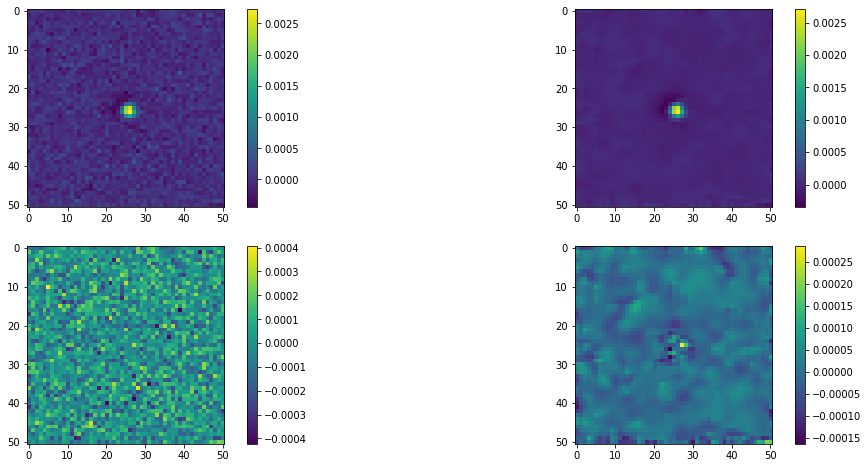

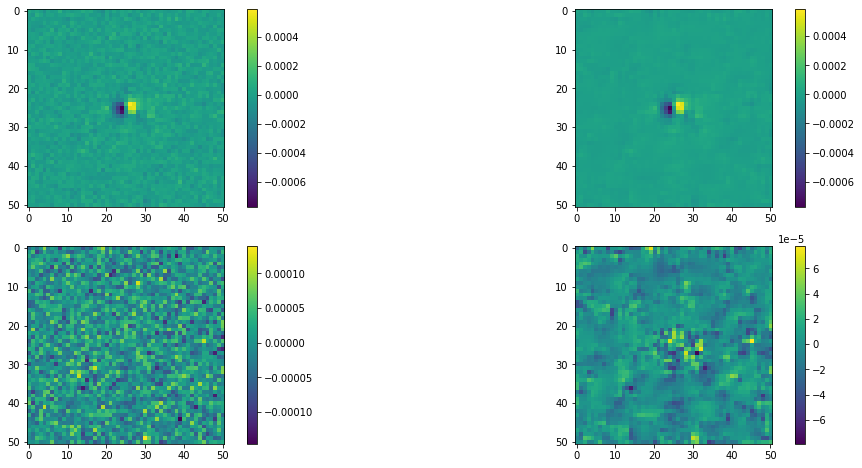

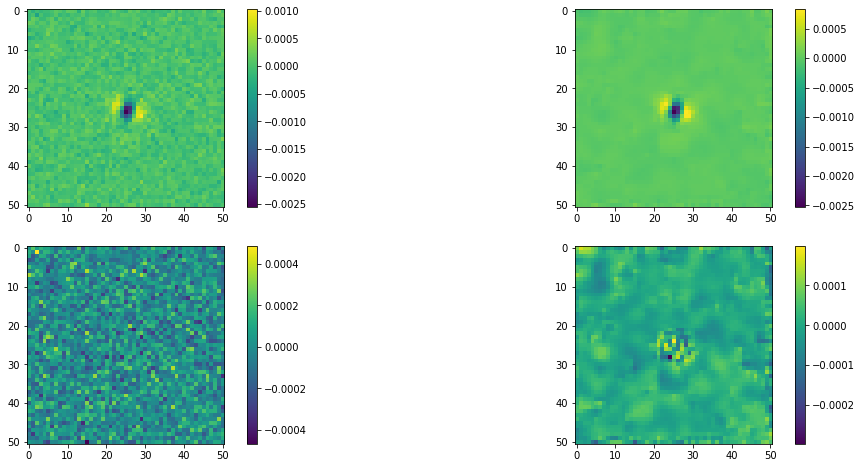

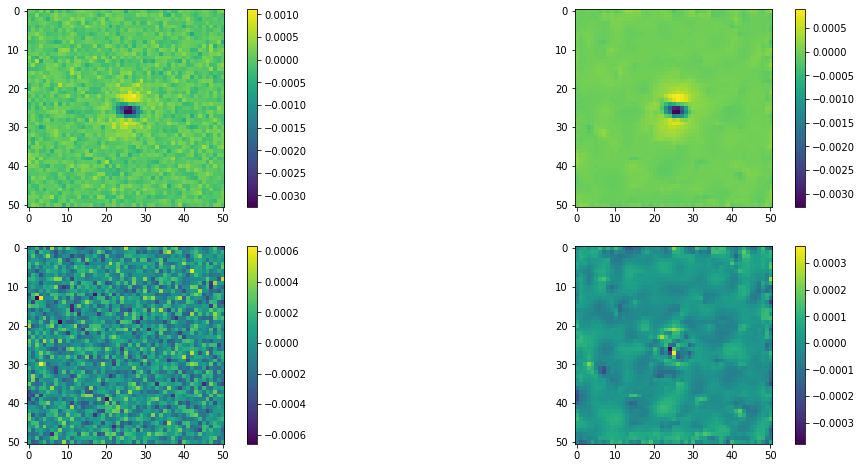

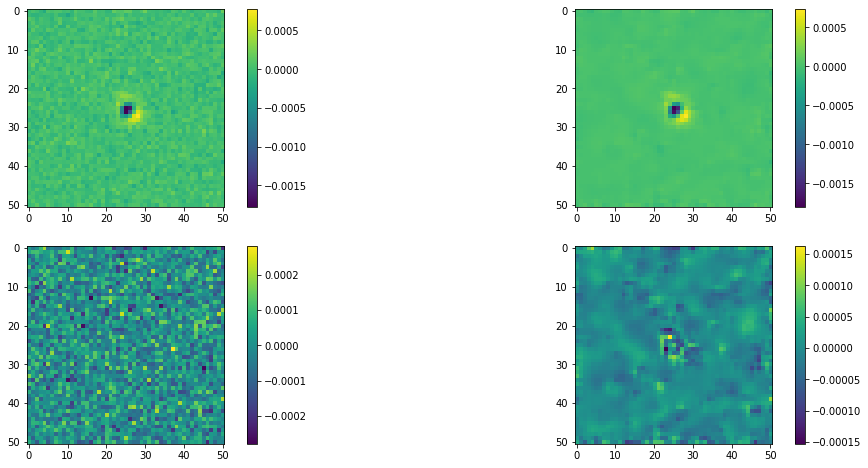

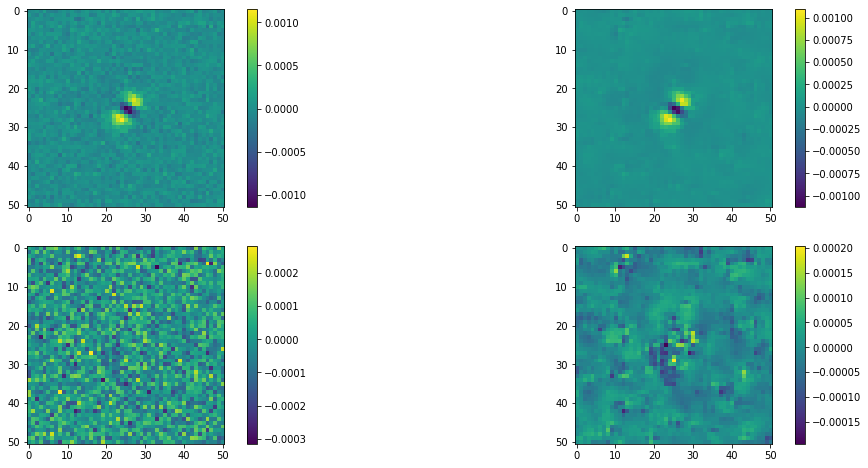

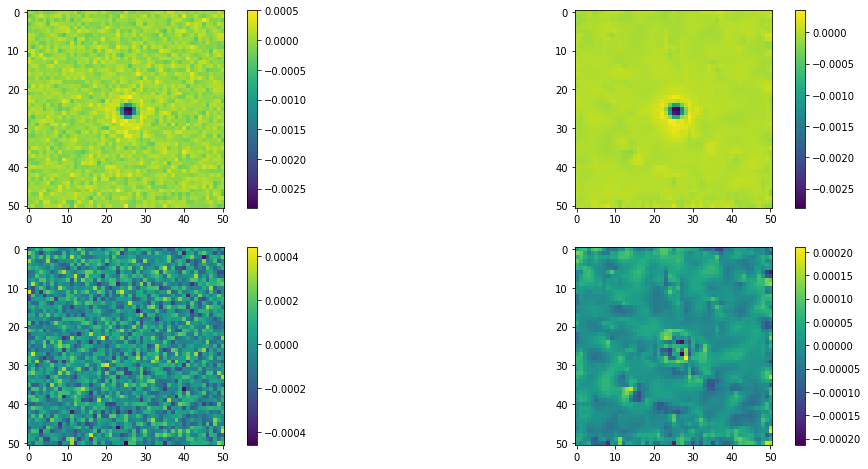

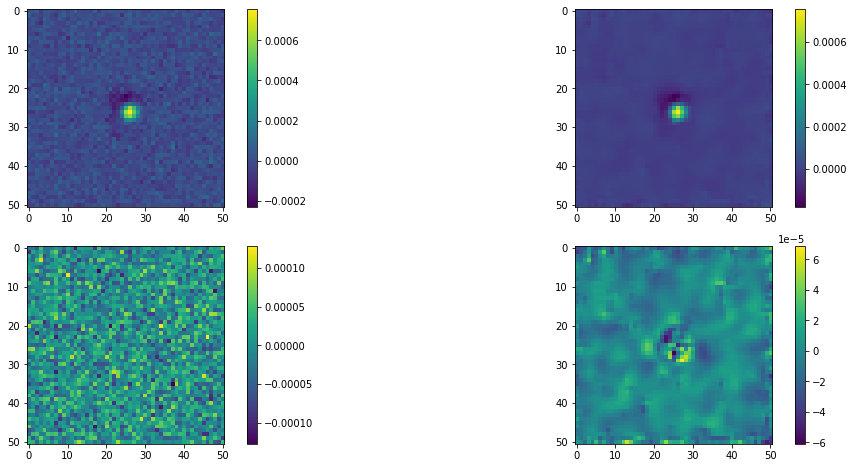

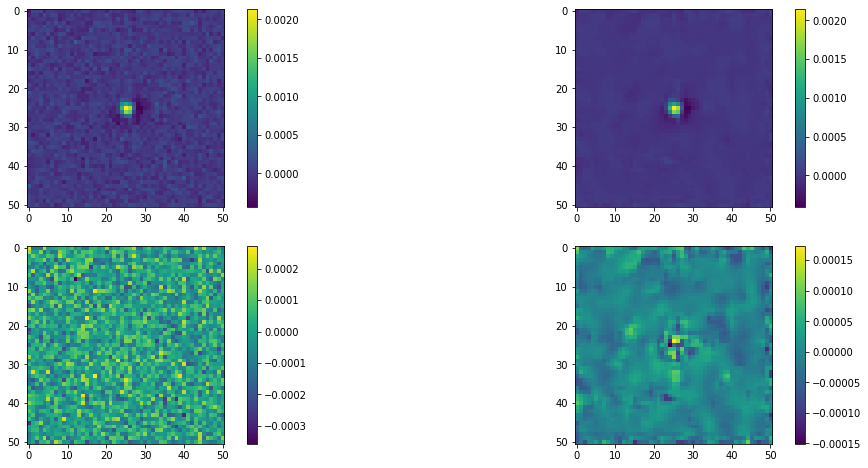

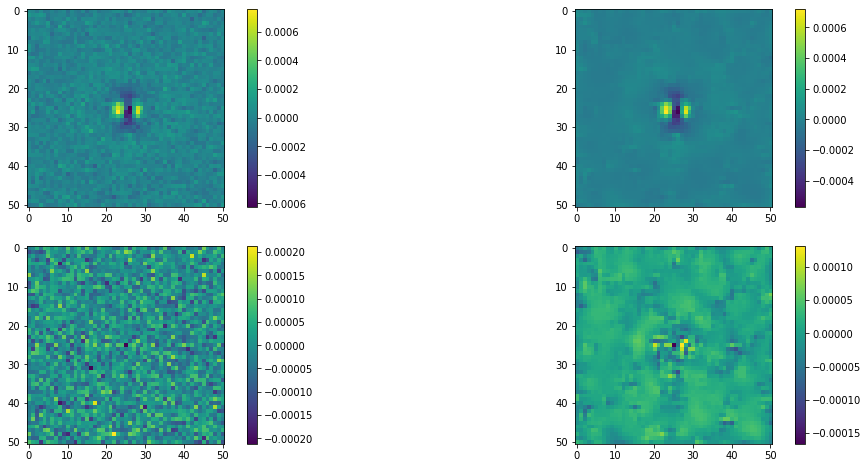

In [40]:
for it in range(10):
    figure(figsize=(18,8))
    subplot(221)
    imshow(noisy_test[it,:,:]);colorbar()
    
    subplot(222)
    imshow(denoised_new[it,:,:]);colorbar()
 
    subplot(223)
    imshow(short_eigenPSF[it,:,:] - noisy_test[it,:,:]);colorbar()
    
    subplot(224)
    imshow(short_eigenPSF[it,:,:] - denoised_new[it,:,:]);colorbar()
    
    
    show()


# Check out the spectral norm of the denoiser

In [ ]:
self.u = self.add_weight(
    shape=(1, self.w_shape[-1]),
    initializer=tf.initializers.TruncatedNormal(stddev=0.02),
    trainable=False,
    name="sn_u",
    dtype=self.w.dtype,
)

w = tf.reshape(self.w, [-1, self.w_shape[-1]])
u = self.u

with tf.name_scope("spectral_normalize"):
    for _ in range(self.power_iterations):
        v = tf.math.l2_normalize(tf.matmul(u, w, transpose_b=True))
        u = tf.math.l2_normalize(tf.matmul(v, w))
    u = tf.stop_gradient(u)
    v = tf.stop_gradient(v)
    sigma = tf.matmul(tf.matmul(v, w), u, transpose_b=True)
    self.u.assign(tf.cast(u, self.u.dtype))
    self.w.assign(
        tf.cast(tf.reshape(self.w / sigma, self.w_shape), self.w.dtype)
    )
